# Task 3 - Reinforcement Learning

After evaluating few of my ideas, I decided on implementing reinforcement learning algorithm for basic stock trading.

In this algorithm, the main agenda is to implement bot/agent which is trained on historic price data of a stock and then it predicts wether to **Buy**, **Sell** or **Hold** the shares of the respective company, and if so, how many shares to buy/sell, to maximise profit. We do this using a Deep Q Reinforcement Learning Algorithm.

Closing value of a share for each day from `2010-08-12` to `2018-08-10` is used for this model to train it. 

In [18]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from numpy.random import choice
import random


### Importing and Cleaning Dataset

I am going to use `TSLA.csv` to train and test the model. 

In [19]:
dataset = pd.read_csv('TSLA.csv', index_col = 0)

In [20]:
pd.set_option('display.width', 100)
pd.set_option('display.precision', 3)
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2014.000,2014.000,2014.000,2014.000,2014.000,2.014e+03
mean,167.950,170.817,164.945,167.955,167.955,4.812e+06
std,112.550,114.210,110.779,112.543,112.543,4.377e+06
min,17.800,17.900,17.390,17.600,17.600,1.185e+05
25%,32.762,33.442,32.048,32.783,32.783,1.493e+06
50%,199.870,203.295,196.380,200.030,200.030,3.919e+06
75%,250.000,253.260,246.137,249.985,249.985,6.356e+06
max,386.690,389.610,379.350,385.000,385.000,3.716e+07


## Train and Test

Now, once we have the `dataset`, we will split the Closing values in it into testing and training sets, after making sure all the data is of float type. 

In [22]:
X=list(dataset["Close"])
X=[float(x) for x in X]

validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

## Agent Script

Now to create the Deep Reinforcement Learning Agent class, we will first need to imoport the required libraries.

Then we initialize our `Agent` with parameters `state_size` and `is_eval` along with setting up other variables which includes `action_size = 3` which is for hold, buy and sell. Setting up `memory` to store past experiences, and then define the algorithm with `gamma`, `epsilon`, `model` etc.

After initializing, we define Agent's methods which are:

`_model` : We define a deep learning model which takes in the current state and based oin it gives out Q values for each Action-Quantity pair for that state.

`act` : This method further predicts the Q-values and selects the action-quantity pair with the highest Q-value, or it may also select it at random for exploration.

`expReplay` : Experience Replay updates the agent's Q-values by training on a sampled mini-batch from memory, adjusting targets with discounted future rewards, and decays the exploration rate.



In [23]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque

class Agent:
    
    def __init__(self, state_size, is_eval=False):
        self.state_size = state_size
        self.action_size = 3
        self.quantity_size = 10 # Can be changed according to preferenbnce
        self.memory = deque(maxlen=1000)
        self.is_eval = is_eval
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._model()

        self.avg_buy_price = 0
        self.budget = 10000
        self.shares = 0 

    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=16, activation="relu"))
        model.add(Dense(self.action_size * self.quantity_size, activation="linear"))
        model.compile(loss=keras.losses.mean_squared_error, optimizer=Adam(learning_rate=0.001))
        return model
        
    def act(self, state):
        if self.is_eval:
            options = self.model.predict(state, verbose=0)
            return np.unravel_index(np.argmax(options), (self.action_size, self.quantity_size))
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size), random.randrange(self.quantity_size)
        options = self.model.predict(state, verbose=0)
        return np.unravel_index(np.argmax(options), (self.action_size, self.quantity_size))

    

    def expReplay(self, batch_size):
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
        
        for state, action, quantity, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                next_q_values = self.model.predict(next_state, verbose=0)[0]
                target = reward + self.gamma * np.max(next_q_values)
            
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action * self.quantity_size + quantity] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



Now we define other functions we will be using.

`getState` : It takes in the date, index of the stock price data and window size as arguments. It extracts window depending on if it can or not and then returns the state as np array of percentage change between consecutive data points.

`calculate_reward` : Calculates the reward based on the action taken. 
 - For `hold` it either rewards or penalizes based on price movement.
 - For `buy` there is no immediate reward/loss
 - For `sell` it rewards for profit as well as opportunity cost

`plot_behaviour` : This function is used to print the stock graph with buy and sell points on it.


In [24]:
def formatPrice(n):
    return f"${n:.2f}"

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append((block[i + 1] - block[i]) / block[i])
    return np.array([res])

def calculate_reward(action, quantity, current_price, next_price, avg_buy_price, shares):
    if action == 0:  # Hold
        return (next_price - current_price) * shares  
    elif action == 1:  # Buy
        return 0  
    elif action == 2 and shares > 0:  # Sell
        profit = (current_price - avg_buy_price) * quantity
        return profit + (next_price - current_price) * (shares - quantity) 
    else:
        return 0

def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize=(15, 5))
    plt.plot(data_input, color='b', lw=2.)
    plt.plot(data_input, 'o', markersize=5, color='r', label='Selling signal', markevery=states_sell)
    plt.plot(data_input, 'o', markersize=5, color='g', label='Buying signal', markevery=states_buy)
    plt.title(f'Total gains: ${profit:.2f}')
    plt.legend()
    plt.show()


## Training

Now to train the model, first we setup with the following variables before running the training loop.

Once we have set up, we run the training loop which for each episode `e` initializes the `state` function, `total_profit` variable, agent variables as well as buy and sell tracker.

Then for each time step it selects an action and quantity. updates its state and then performs the action it chose. Then we calculate the reward based on the action it chose. Then it adds experience to its memory and updates the state.

Initially had an issue implementing the correct way to implement or use the state of the function. The way I went about it was to predict action and quantity for the current state and then we get next_state for next iteration, they both are also saved in memory before `state = next_state`. 

At the end of each episode if memory size exceeds batch size we call agent.expReplay(batch_size) to update the model using experience replay.

C:\Users\AKSHAT\anaconda3\envs\Krutanics\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


------------Episode 0/20------------
Episode 0 - Total Profit: $18537.64
Final budget: $17921.58
Shares remaining: 5


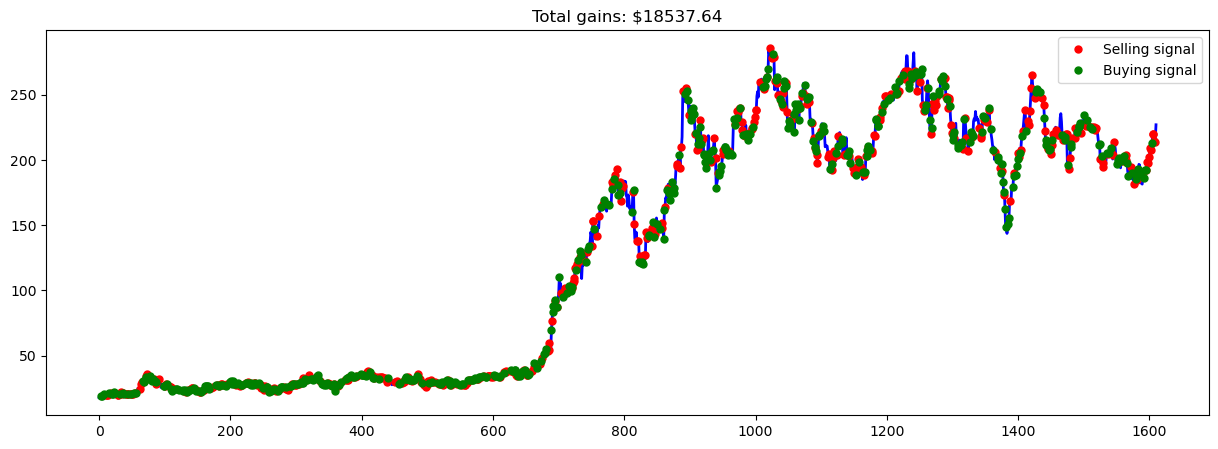

------------Episode 1/20------------
Episode 1 - Total Profit: $8228.24
Final budget: $20472.15
Shares remaining: 42


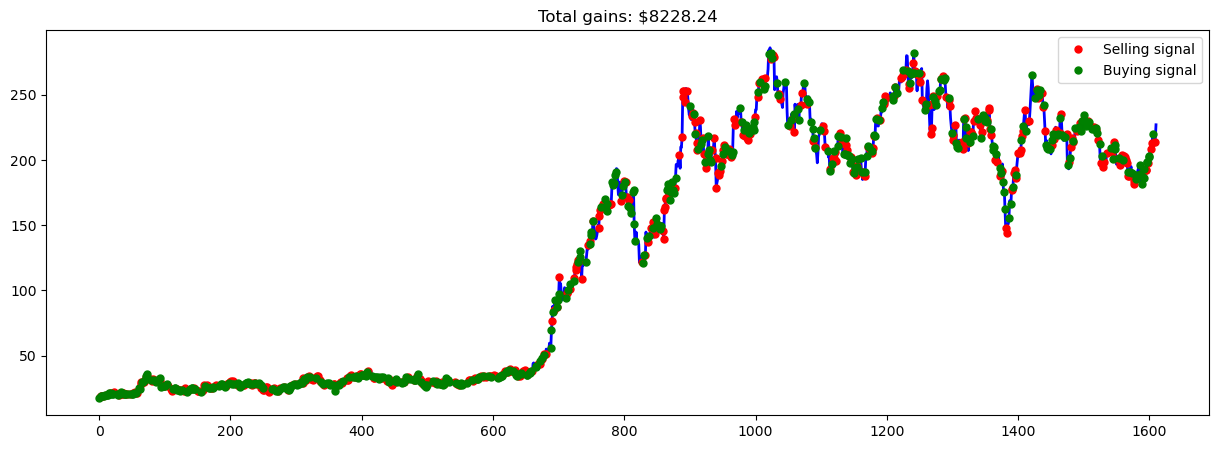

------------Episode 2/20------------
Episode 2 - Total Profit: $27027.51
Final budget: $49404.20
Shares remaining: 52


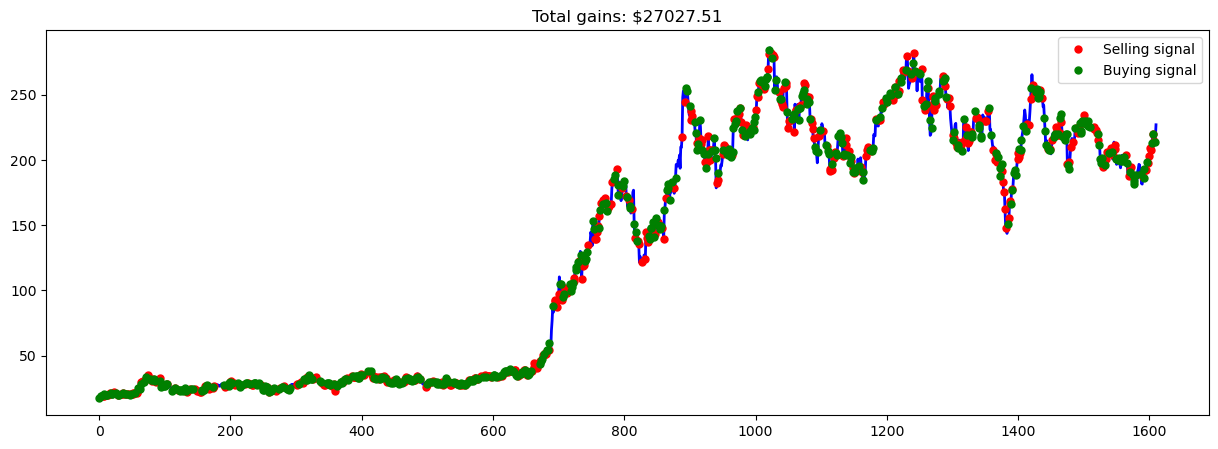

------------Episode 3/20------------
Episode 3 - Total Profit: $21564.40
Final budget: $24251.35
Shares remaining: 20


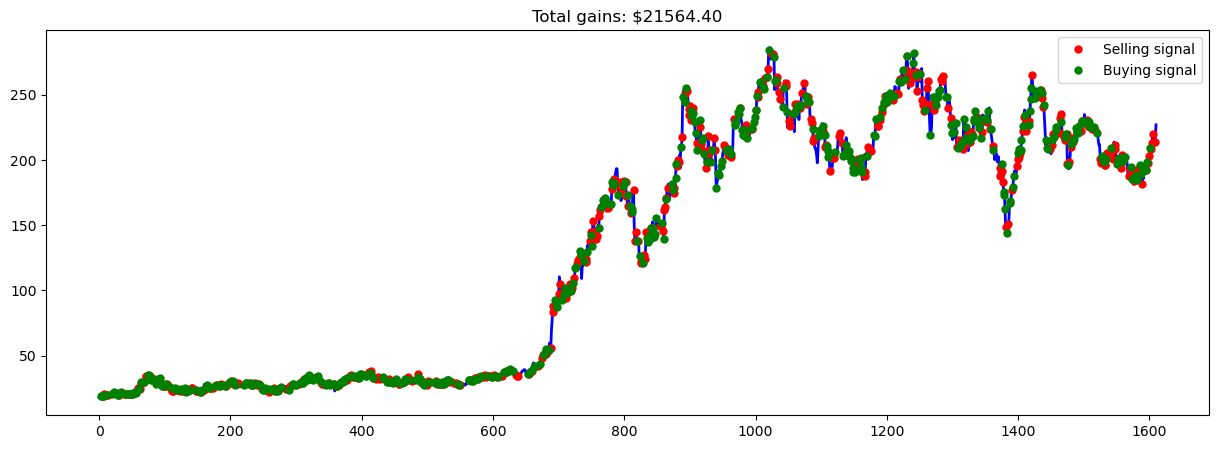

------------Episode 4/20------------
Episode 4 - Total Profit: $27692.32
Final budget: $67408.85
Shares remaining: 34


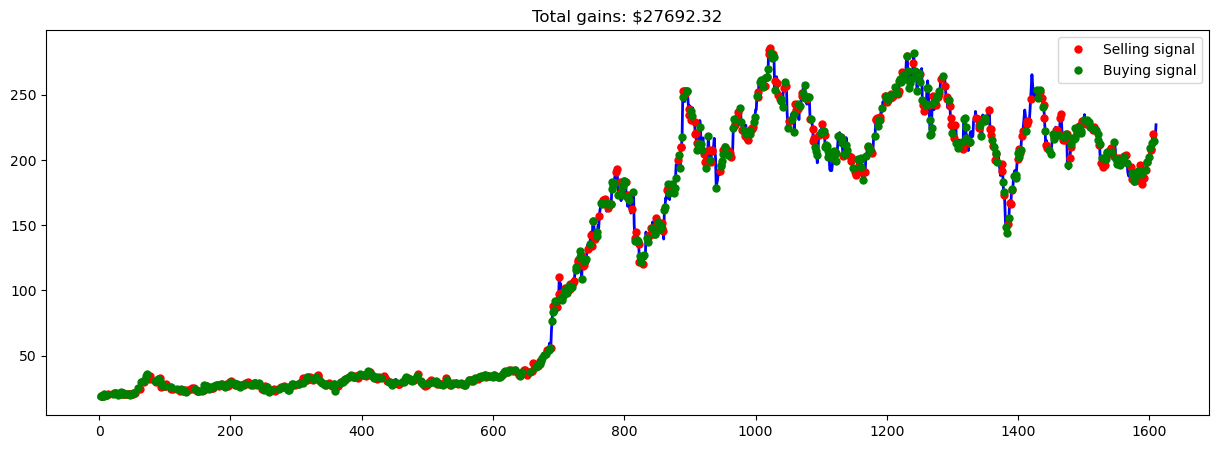

------------Episode 5/20------------
Episode 5 - Total Profit: $2368.47
Final budget: $13407.81
Shares remaining: 19


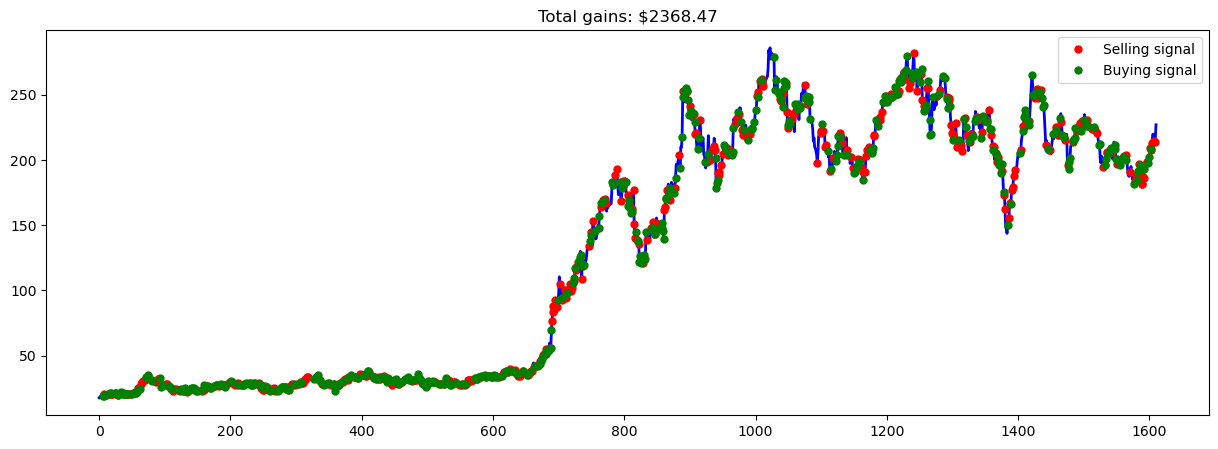

------------Episode 6/20------------
Episode 6 - Total Profit: $6254.86
Final budget: $2441.86
Shares remaining: 61


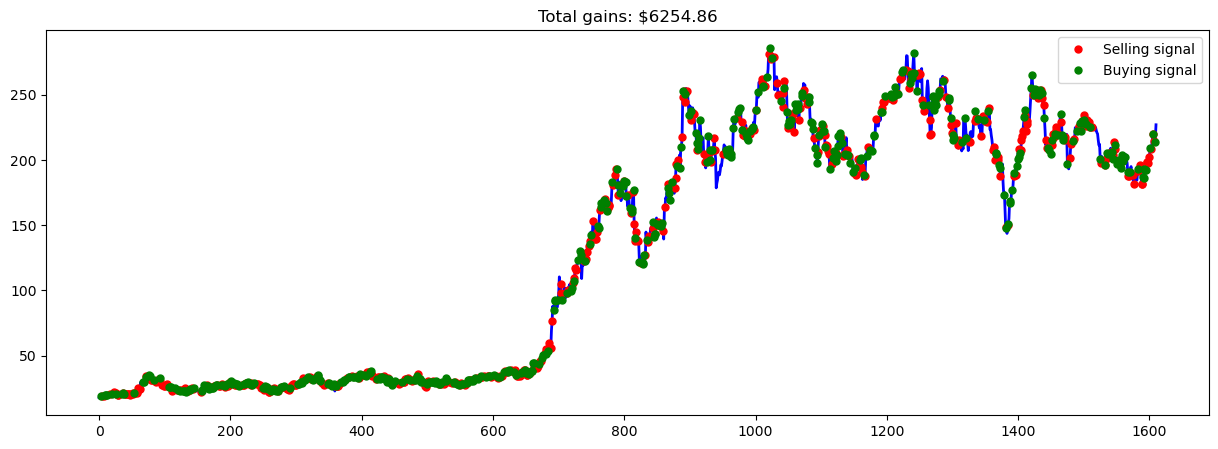

------------Episode 7/20------------
Episode 7 - Total Profit: $35420.57
Final budget: $43151.42
Shares remaining: 0


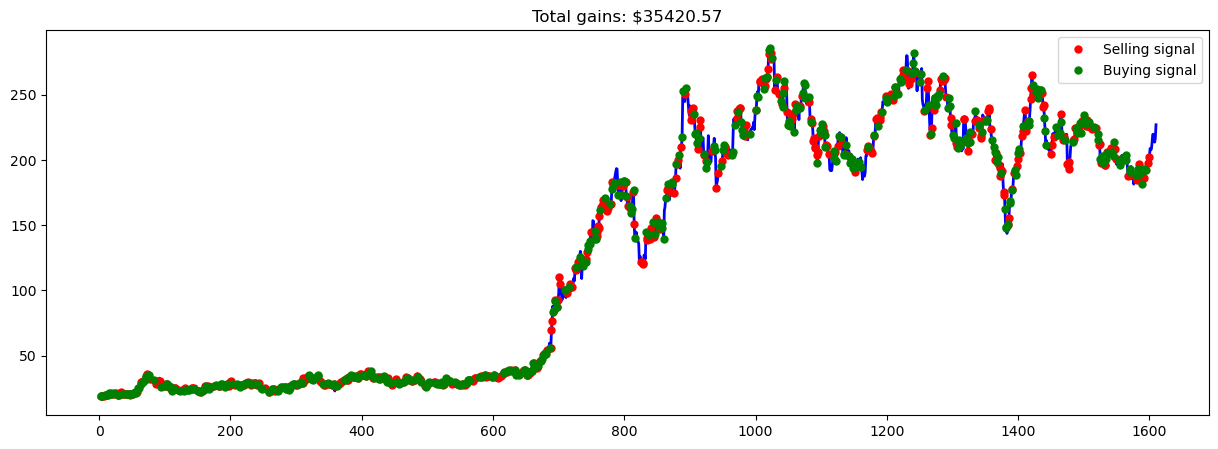

------------Episode 8/20------------
Episode 8 - Total Profit: $10558.44
Final budget: $2824.82
Shares remaining: 102


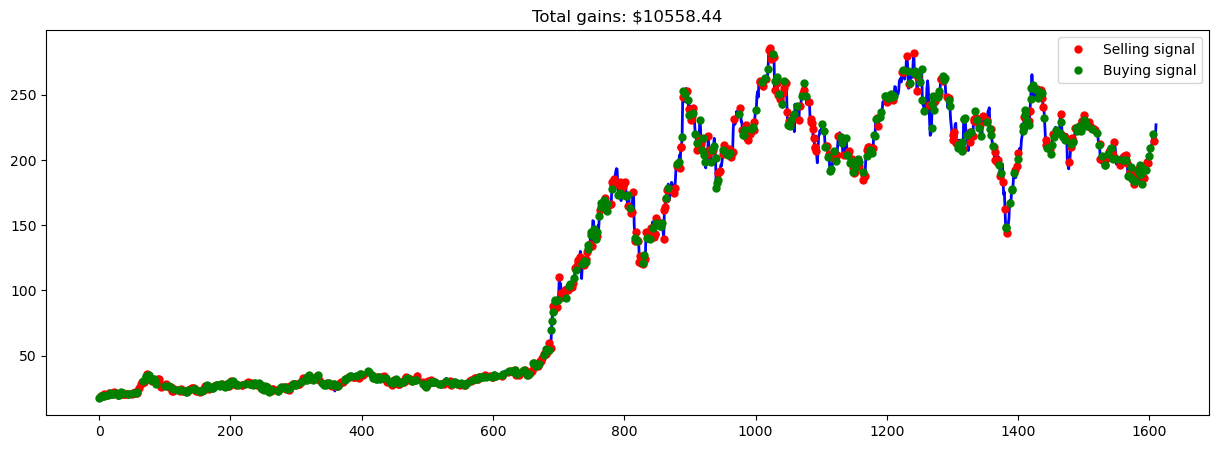

------------Episode 9/20------------
Episode 9 - Total Profit: $34242.81
Final budget: $21180.88
Shares remaining: 95


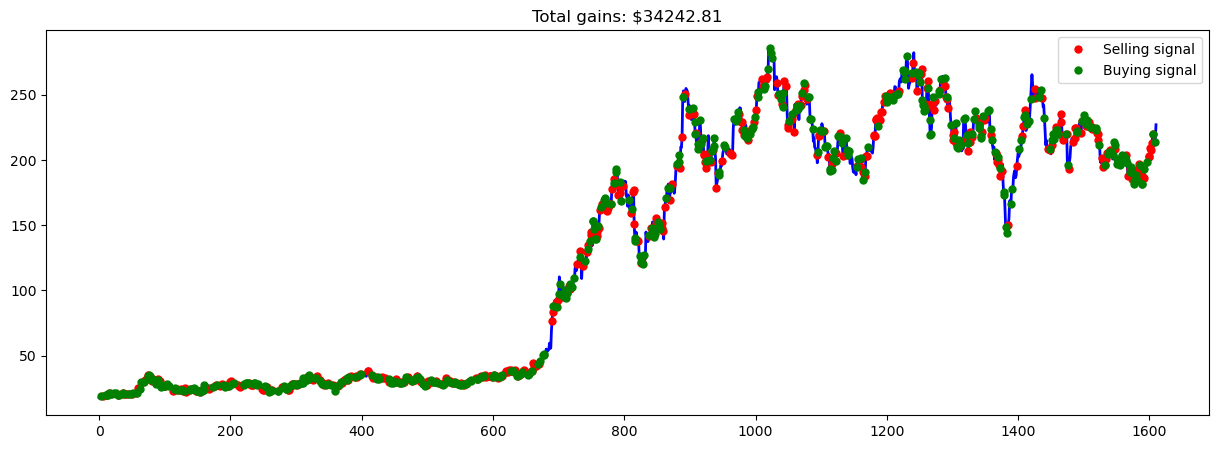

------------Episode 10/20------------
Episode 10 - Total Profit: $26511.22
Final budget: $63352.85
Shares remaining: 1


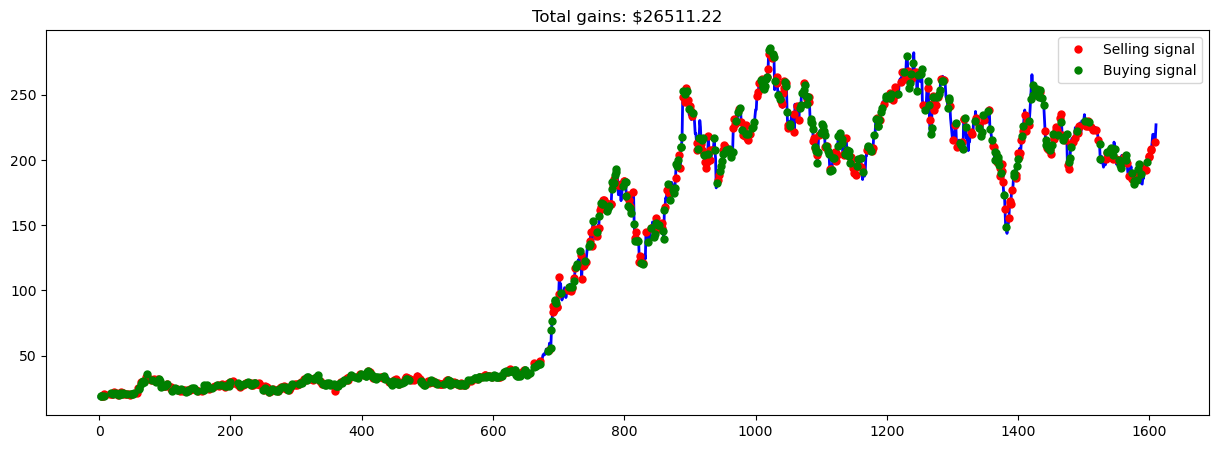

------------Episode 11/20------------
Episode 11 - Total Profit: $34757.92
Final budget: $17494.81
Shares remaining: 124


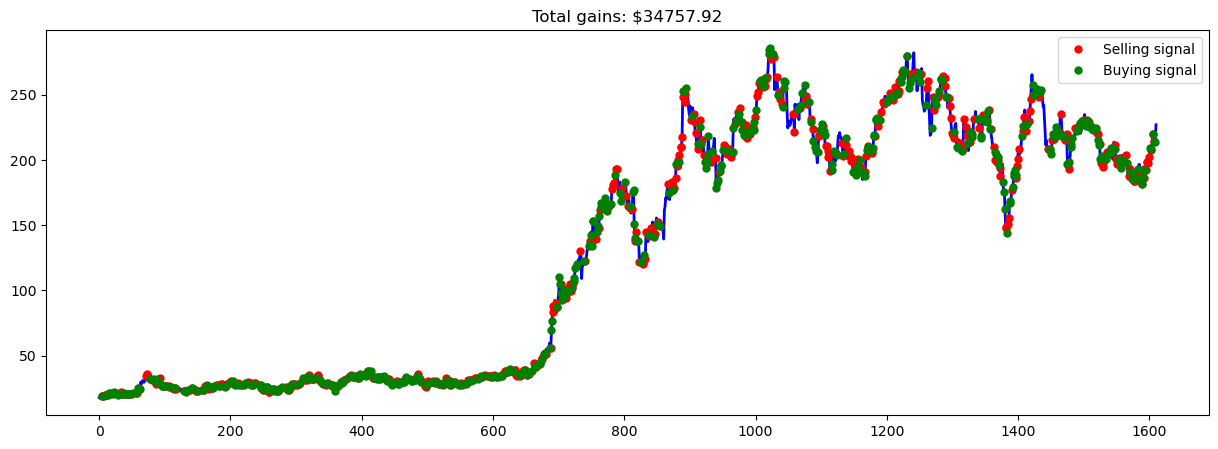

------------Episode 12/20------------
Episode 12 - Total Profit: $24159.04
Final budget: $30926.56
Shares remaining: 80


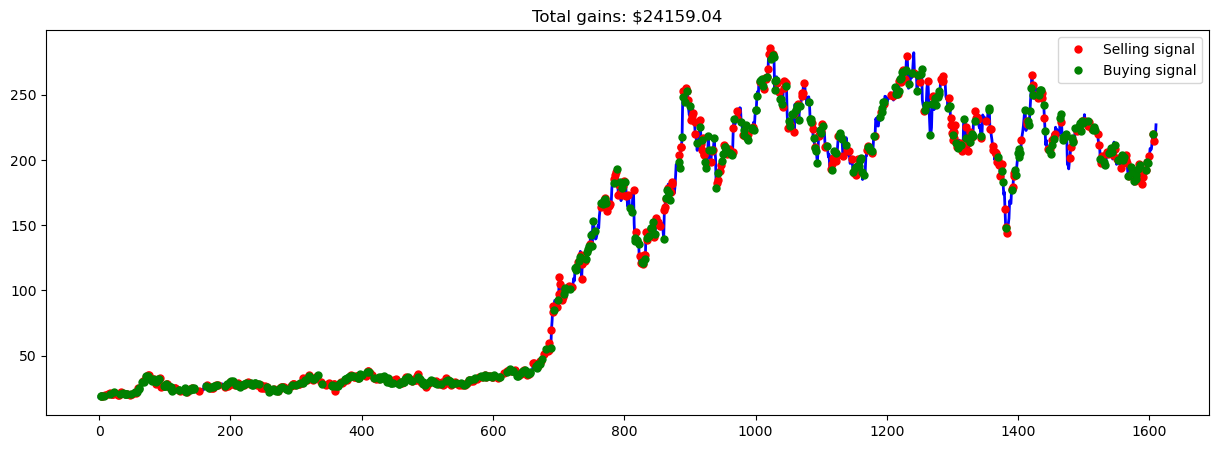

------------Episode 13/20------------
Episode 13 - Total Profit: $7035.56
Final budget: $24263.49
Shares remaining: 1


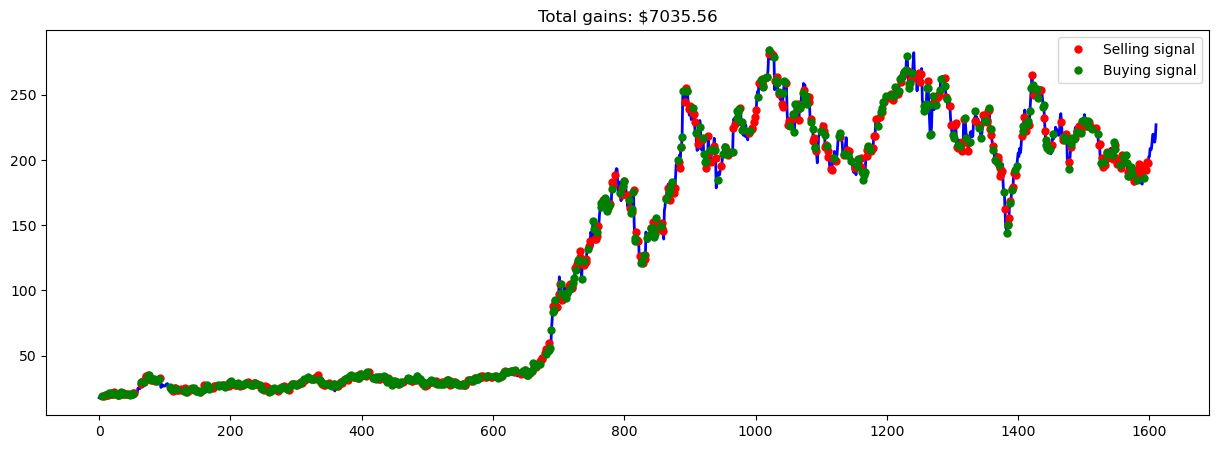

------------Episode 14/20------------
Episode 14 - Total Profit: $26556.09
Final budget: $35033.85
Shares remaining: 64


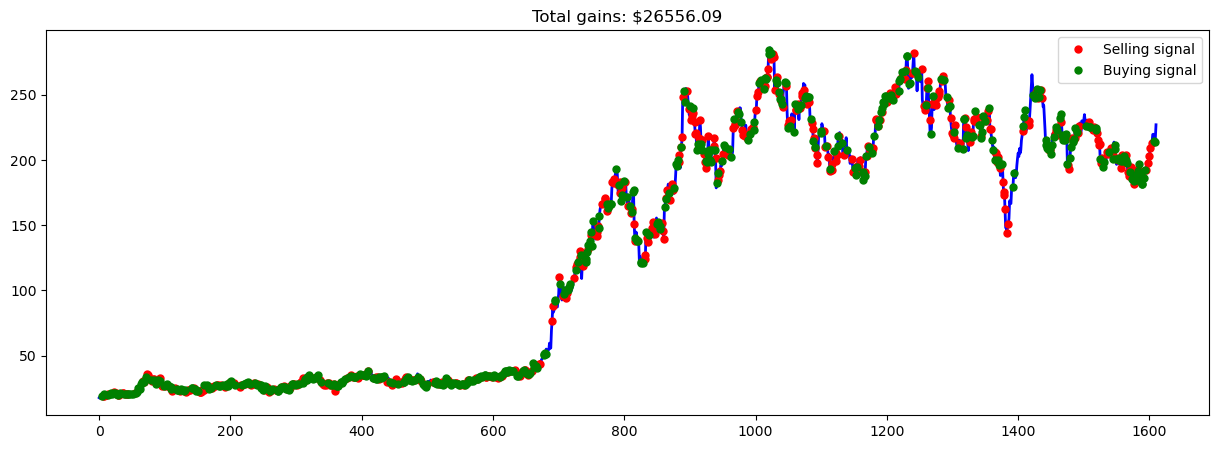

------------Episode 15/20------------
Episode 15 - Total Profit: $7525.95
Final budget: $18667.15
Shares remaining: 3


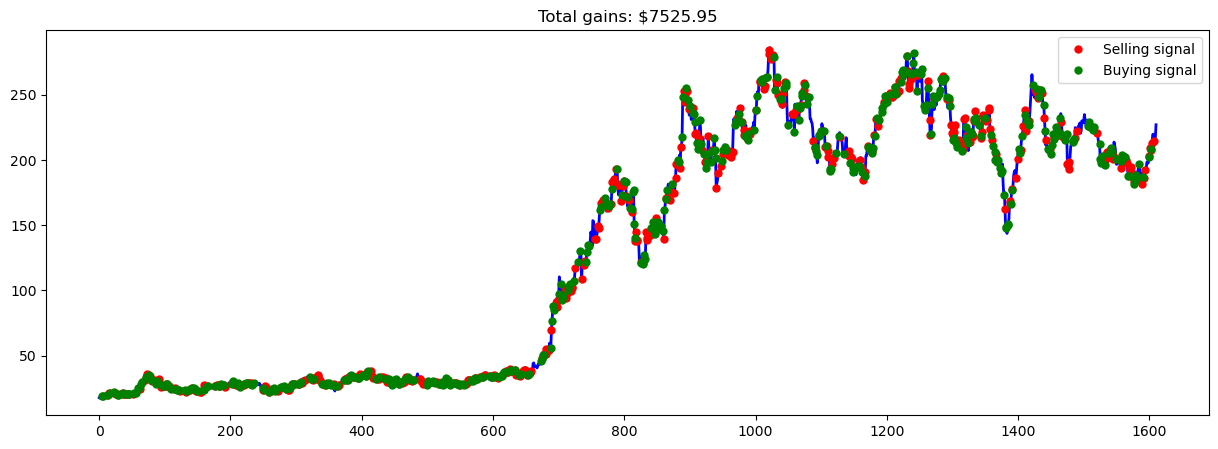

------------Episode 16/20------------
Episode 16 - Total Profit: $7515.86
Final budget: $50791.28
Shares remaining: 65


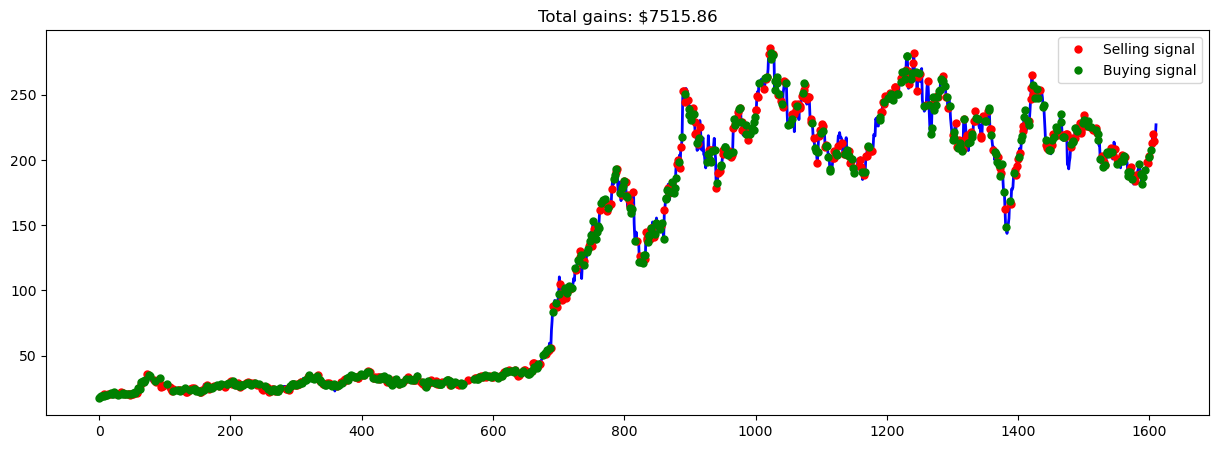

------------Episode 17/20------------
Episode 17 - Total Profit: $13187.30
Final budget: $1813.86
Shares remaining: 79


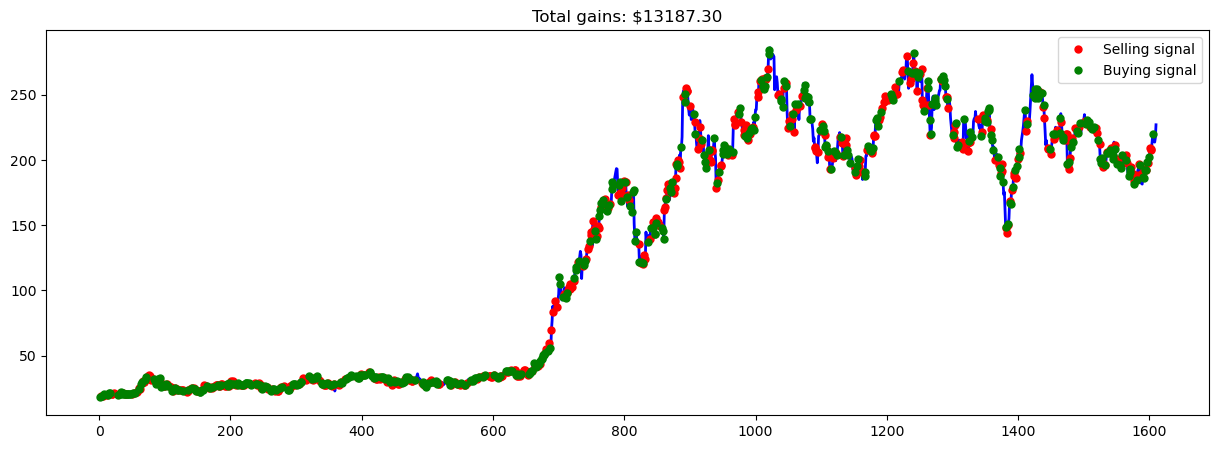

------------Episode 18/20------------
Episode 18 - Total Profit: $14703.45
Final budget: $145.30
Shares remaining: 141


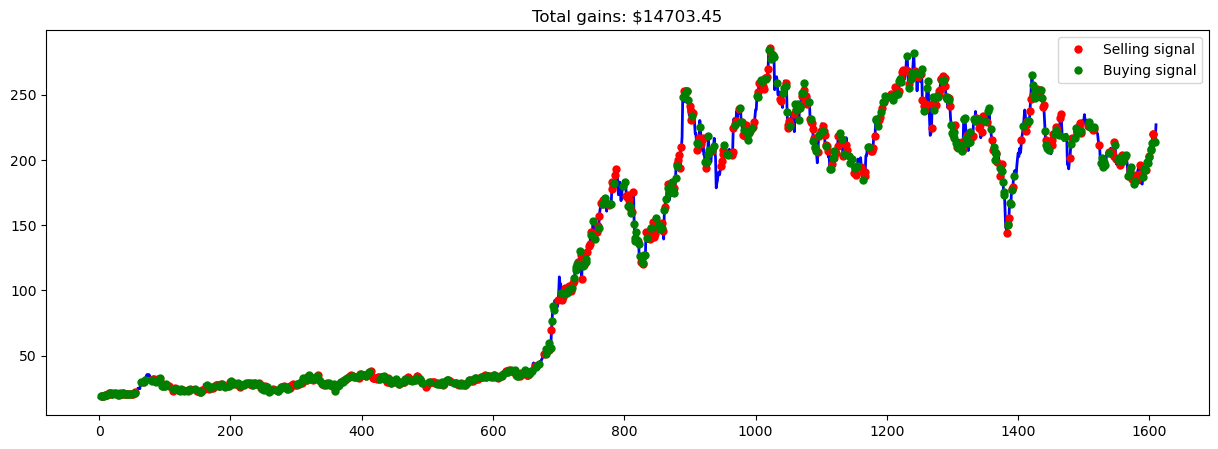

------------Episode 19/20------------
Episode 19 - Total Profit: $4679.94
Final budget: $40.04
Shares remaining: 107


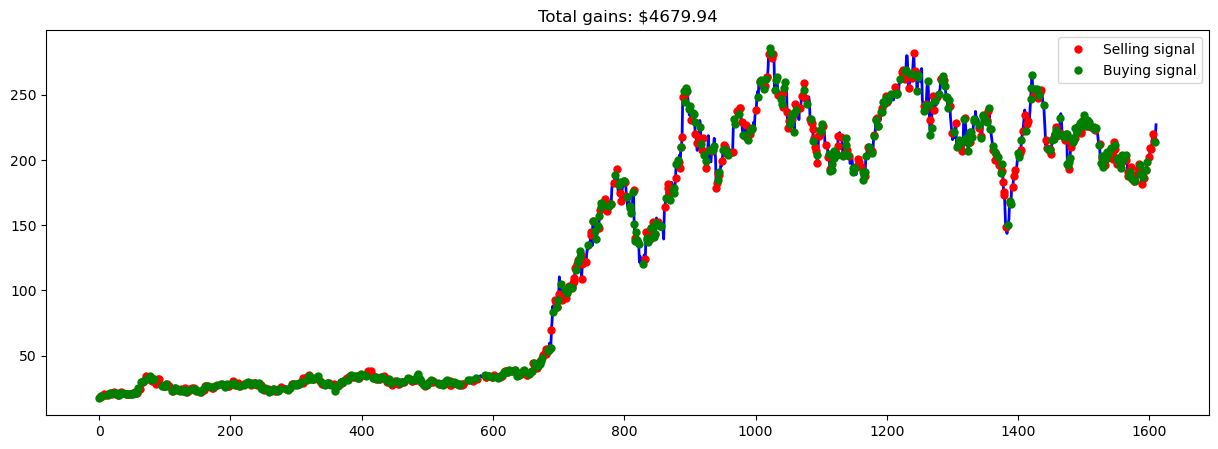

------------Episode 20/20------------
Episode 20 - Total Profit: $28506.46
Final budget: $212.48
Shares remaining: 223


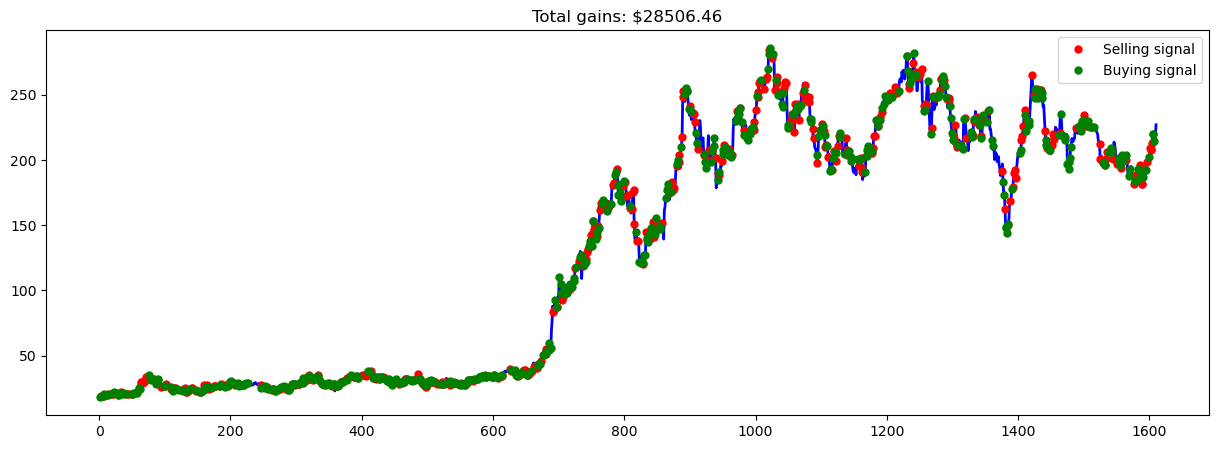

In [25]:

window_size = 30
agent = Agent(window_size)
data = X_train
l = len(data) - 1
batch_size = 32
episode_count = 20 

for e in range(episode_count + 1):
    print(f"------------Episode {e}/{episode_count}------------")
    state = getState(data, 0, window_size + 1) # Reset at start of each episode
    total_profit = 0
    agent.shares = 0
    agent.avg_buy_price = 0
    agent.budget = 10000  
    states_buy = []
    states_sell = []

    for t in range(l - 1):  # Note the change to l - 1
        action, quantity = agent.act(state)
        next_state = getState(data, t + 1, window_size + 1)
        
        if action == 1:  # buy
            max_affordable = agent.budget // data[t]
            shares_to_buy = min(int(max_affordable * (quantity + 1) / agent.quantity_size), max_affordable)
            if shares_to_buy > 0:
                cost = shares_to_buy * data[t]
                agent.avg_buy_price = (agent.avg_buy_price * agent.shares + cost) / (agent.shares + shares_to_buy)
                agent.shares += shares_to_buy
                agent.budget -= cost
                states_buy.append(t)
        elif action == 2 and agent.shares > 0:  # sell
            shares_to_sell = min(int(agent.shares * (quantity + 1) / agent.quantity_size), agent.shares)
            if shares_to_sell > 0:
                sold_price = shares_to_sell * data[t]
                agent.budget += sold_price
                agent.shares -= shares_to_sell
                states_sell.append(t)

        reward = calculate_reward(action, quantity, data[t], data[t+1], agent.avg_buy_price, agent.shares)
        total_profit += reward

        done = t == l - 2
        agent.memory.append((state, action, quantity, reward, next_state, done))
        state = next_state # Update the state variable for next iteration

        if done:
            print(f"Episode {e} - Total Profit: {formatPrice(total_profit)}")
            print(f"Final budget: {formatPrice(agent.budget)}")
            print(f"Shares remaining: {agent.shares}")
            plot_behavior(data, states_buy, states_sell, total_profit)

    if len(agent.memory) > batch_size:
        agent.expReplay(batch_size)



## Testing

Now once we have trained our model, we need to evaluate it, and hence we change agent.is_eval to true. 

We set up all the variables for testing. Before using the Agent function for testing through is_eval, I tried to use keras' `model.save` function to save my model and then load it but it was causing me errors as it was only holding and not performing any other action for some reason. Changing to is_eval method worked but I have to see through the issue with the saving method.

In [26]:

print("\nTesting the trained model:")
agent.is_eval = True  # Switch to evaluation mode
l_test = len(X_test) - 1
state = getState(X_test, 0, window_size + 1)
total_profit = 0
states_buy = []
states_sell = []

agent.budget = 10000
agent.shares = 0
agent.avg_buy_price = 0

model_summary = agent.model.summary() # Debugging
print(model_summary)


Testing the trained model:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 30)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,308 (59.80 KB)

 Trainable params: 5,102 (19.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,206 (39.87 KB)

None


We run the test loop which is almost same as the time step loop we used in training.

Action: 1, Quantity: 8
Buy: 39 shares at $226.75
Action: 0, Quantity: 2
Action: 0, Quantity: 3
Action: 0, Quantity: 5
Action: 0, Quantity: 9
Action: 2, Quantity: 0
Sell: 3 shares at $229.59 | Profit: $8.52
Action: 0, Quantity: 6
Action: 2, Quantity: 4
Sell: 18 shares at $235.58 | Profit: $158.94
Action: 0, Quantity: 6
Action: 1, Quantity: 4
Buy: 12 shares at $243.76
Action: 0, Quantity: 3
Action: 1, Quantity: 8
Buy: 10 shares at $248.92
Action: 1, Quantity: 5
Buy: 1 shares at $254.61
Action: 1, Quantity: 7
Action: 2, Quantity: 8
Sell: 36 shares at $252.51 | Profit: $529.01
Action: 2, Quantity: 3
Sell: 2 shares at $252.95 | Profit: $30.27
Action: 2, Quantity: 2
Action: 1, Quantity: 3
Buy: 15 shares at $251.93
Action: 0, Quantity: 5
Action: 2, Quantity: 5
Sell: 10 shares at $251.55 | Profit: $19.72
Action: 1, Quantity: 7
Buy: 27 shares at $251.33
Action: 2, Quantity: 8
Sell: 31 shares at $257.77 | Profit: $212.06
Action: 1, Quantity: 8
Buy: 34 shares at $257.48
Action: 1, Quantity: 3
Buy

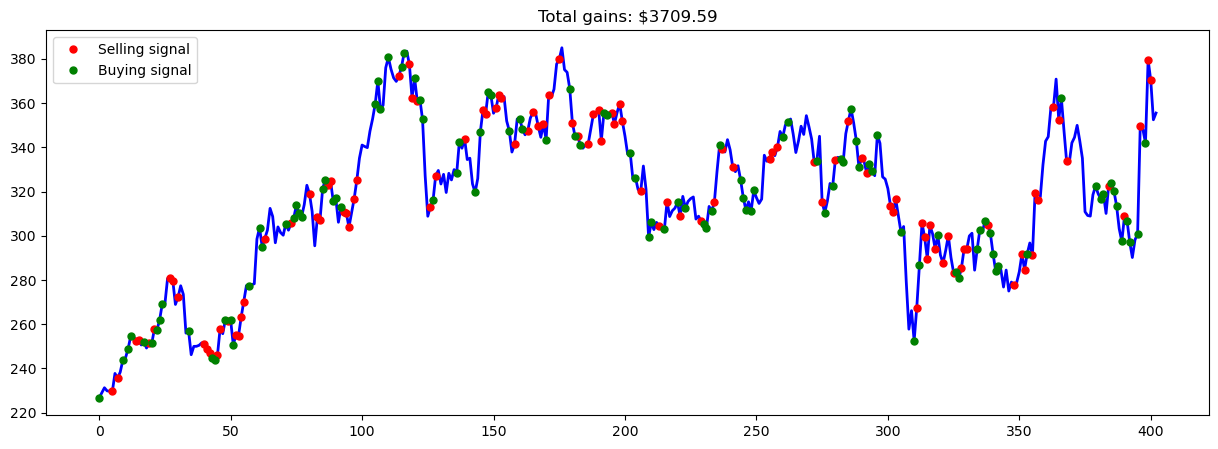

In [28]:

for t in range(l_test):
    action, quantity = agent.act(state)
        
    print(f"Action: {action}, Quantity: {quantity}")
    next_state = getState(X_test, t + 1, window_size + 1)
    if action == 1:  # buy
        max_affordable = agent.budget // X_test[t]
        shares_to_buy = int(max_affordable * (quantity + 1) / agent.quantity_size)
        if shares_to_buy > 0:
            cost = shares_to_buy * X_test[t]
            agent.avg_buy_price = (agent.avg_buy_price * agent.shares + cost) / (agent.shares + shares_to_buy)
            agent.shares += shares_to_buy
            agent.budget -= cost
            states_buy.append(t)
            print(f"Buy: {shares_to_buy} shares at {formatPrice(X_test[t])}")
    elif action == 2 and agent.shares > 0:  # sell
        shares_to_sell = int(agent.shares * (quantity + 1) / agent.quantity_size)
        if shares_to_sell > 0:
            sold_price = shares_to_sell * X_test[t]
            agent.budget += sold_price
            profit = (X_test[t] - agent.avg_buy_price) * shares_to_sell
            agent.shares -= shares_to_sell
            total_profit += profit
            states_sell.append(t)
            print(f"Sell: {shares_to_sell} shares at {formatPrice(X_test[t])} | Profit: {formatPrice(profit)}")
    state = next_state

print("------------------------------------------")
print(f"Total Profit: {formatPrice(total_profit)}")
print(f"Final budget: {formatPrice(agent.budget)}")
print(f"Shares remaining: {agent.shares}")
print("------------------------------------------")
plot_behavior(X_test, states_buy, states_sell, total_profit)

In the end, after running the test we got a profit of about $3709.59. 

Of course there is still room for improvement for this model and few things that needs work. I wanted to add multiple parameters in the state but with the issues this model was facing I had to stop working on that. I believe this model can still be further optimised and would like to incorporate in the future.

Things I'd like to try in the future that might improve the model includes using a little more complex neural network architecture (perhaps LSTM), increasing the number of episodes or even using huber loss function instead of mse. But in case of stock market trading, one thing that can definitely improve the model would be adding sentimental analysis to it, which is the topic I'd like research more on.

We can see that the model creates a stock market strategy based on its training data and does give a profit with just a few parameters set by us. That is a positive thing for future work.  